https://www.ctcms.nist.gov/fipy/documentation/glossary.html#term-trilinos

In [1]:
# Complicated way to import finis if not installed

import os
import sys
finis_path = "../tp" #Folder containing finis folder
finis_abs_path = os.path.abspath(finis_path)
sys.path.append(finis_abs_path)

import finis
import numpy as np
import scipy.sparse as sp
import scipy
import pyamg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
%matplotlib inline

### Question 9: Setup

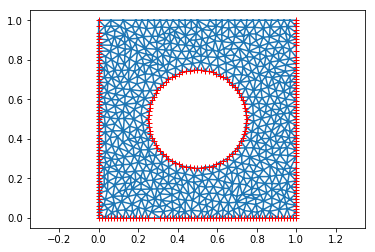

In [3]:
mesh = finis.triangulate(max_area=0.001, geom='square-disk', n=20)
fe_u = finis.fe_space(mesh, order=2, order_int=2)
fe_p = finis.fe_space(mesh, order=1, order_int=2)
finis.plot_mesh(mesh, fig=plt.figure())

if True:
    markers = fe_u['markers']
    free_upper_boundary = True

    if free_upper_boundary:
        markers = np.logical_and(markers,
                                 np.logical_or(fe_u['dof'][:,1] < 1.0, np.logical_or(
                                               fe_u['dof'][:,0] == 0,
                                               fe_u['dof'][:,0] == 1)))
    plt.plot(fe_u['dof'][markers==1,0], fe_u['dof'][markers==1,1], 'r+')
    plt.axis("equal")

assert np.array_equal(fe_u['integ'], fe_p['integ']), "FE Spaces not compatible"
assert np.array_equal(fe_u['w'], fe_p['w']), "FE integration weights not compatible"

### Smooth step function

In [4]:
def step(t):
    res = np.zeros_like(t)
    res[t < 0.249] = np.exp(-1 / (0.25 - t[t < 0.249]) + 4)
    # res[t <= 0] = 1
    return res

In [5]:
f1 = lambda x,y: np.zeros_like(x)
# f2 = lambda x,y: -np.ones_like(y)
f2 = lambda x,y: np.zeros_like(x)
up1 = lambda x,y: np.zeros_like(x)
up2 = lambda x,y: x*(1-x)*step(y)

dim_u1 = fe_u['U'].shape[1]
dim_u2 = dim_u1
dim_p = fe_p['U'].shape[1]
dim_w = fe_u['w'].size

W = sp.spdiags(fe_u['w'], [0], m=dim_w, n=dim_w)


# LHS
var_formulation = 2 # 1 -> nabla(u) : nabla(v), 2 -> (nabla(u) + nabla(u)^T) : nabla(v)
if var_formulation == 1:
    A11 = fe_u['DUX'].transpose().dot(W).dot(fe_u['DUX']) + fe_u['DUY'].transpose().dot(W).dot(fe_u['DUY'])
    A22 = A11
    A12 = None
    A21 = None
elif var_formulation == 2:
    A11 = fe_u['DUX'].transpose().dot(W).dot(fe_u['DUX']) + fe_u['DUY'].transpose().dot(W).dot(fe_u['DUY'])
    A22 = A11
    A12 = fe_u['DUY'].transpose().dot(W).dot(fe_u['DUX'])
    A21 = A12.transpose()
else:
    raise NotImplementedError("No other Variational Formulations")

A13 = -fe_u['DUX'].transpose().dot(W).dot(fe_p['U'])
A23 = -fe_u['DUY'].transpose().dot(W).dot(fe_p['U'])

# _row = U.transpose().dot(W).dot(np.ones((dim_w,)))[None, :] # Force mean(p) = 0
A = sp.bmat([[A11, A12, A13], [A21, A22, A23], [A13.transpose(), A23.transpose(), None]], format='csr')
assert np.allclose((A - A.transpose()).data, 0), "A is not numerically symmetric!"

# RHS
F1int = f1(fe_u['integ'][:,0], fe_u['integ'][:,1])
F2int = f2(fe_u['integ'][:,0], fe_u['integ'][:,1])
UP1 = up1(fe_u['dof'][:,0], fe_u['dof'][:,1])
UP2 = up2(fe_u['dof'][:,0], fe_u['dof'][:,1])

_F1 = np.concatenate((
    fe_u['U'].transpose().dot(W).dot(F1int),
    fe_u['U'].transpose().dot(W).dot(F2int),
    np.zeros(dim_p, )
))
    
UHP = np.concatenate((UP1, UP2, np.zeros((dim_p, ))))        
F = _F1 - A.dot(UHP)

In [6]:
row = np.where(markers==0)[0]
col = np.arange(row.size)
data = np.ones((row.size, ), dtype=np.float)
P_u = sp.csr_matrix((data, (row, col)), shape=(markers.size, row.size))

dim_u1d = P_u.shape[1]
dim_u2d = P_u.shape[1]

P = sp.bmat([[P_u, None, None], [None, P_u, None], [None, None, sp.eye(dim_p)]], format='csr')
Ad = P.transpose().dot(A).dot(P)
assert np.allclose((Ad - Ad.transpose()).data, 0), "A is not numerically symmetric!"


Fd = P.transpose().dot(F)

In [7]:
if A.shape[0] <= 100:
    max_val = max([
        abs(A.min()),
        abs(A.max()),
        np.amax(np.abs(F))
    ])

    f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[A.shape[0], 1]}, sharey=True, figsize=(5,4))
    a0.pcolor(A.toarray(), vmin=-max_val, vmax=max_val)
    a0.invert_yaxis()
    a0.axis("equal")
    a0.set_title("A")

    mappable = a1.pcolor(F[:, None], vmin=-max_val, vmax=max_val)
    a1.axis("equal")
    a1.set_title("F")

    plt.suptitle("Sparsity Patterns")
    plt.show()
else:
    print("A  too large for plotting ({})".format(A.shape[0]))
    
if Ad.shape[0] <= 500:
    max_val = max([
        abs(Ad.min()),
        abs(Ad.max()),
        np.amax(np.abs(Fd))
    ])

    f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[Ad.shape[0], 1]}, sharey=True, figsize=(5,4))
    a0.pcolor(Ad.toarray(), vmin=-max_val, vmax=max_val)
    a0.invert_yaxis()
    a0.axis("equal")
    a0.set_title("A")

    mappable = a1.pcolor(Fd[:, None], vmin=-max_val, vmax=max_val)
    a1.axis("equal")
    a1.set_title("F")

    plt.suptitle("Sparsity Patterns: Dirichlet")
    plt.show()
else:
    print("Ad too large for plotting ({})".format(Ad.shape[0]))
    
if Ad.shape[0] <= 500:
    null = scipy.linalg.null_space(Ad.toarray())
    if null.size > 0:
        plt.figure()
        plt.plot(null)
        plt.title("Null Space (dim = {})".format(null.shape[1]))
        plt.show()
    else:
        print("Null space is empty")
else:
    print("Ad too large for null space analysis")

A  too large for plotting (5962)
Ad too large for plotting (5432)
Ad too large for null space analysis


In [8]:
%%time
tol = 1e-8
x = sp.linalg.spsolve(Ad, Fd)
x[2*dim_u1d:] -= np.mean(x[2*dim_u1d:]) # remove mean pressure

print("--- Time ---")

--- Time ---
CPU times: user 113 ms, sys: 72.8 ms, total: 186 ms
Wall time: 105 ms


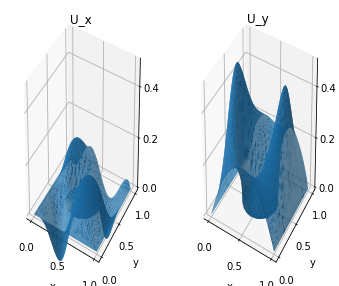

CPU times: user 3.19 s, sys: 501 ms, total: 3.69 s
Wall time: 3.04 s


In [9]:
%%time

u_h = P.dot(x) + UHP
u1d_h = u_h[0:dim_u1]
u2d_h = u_h[dim_u1:dim_u1+dim_u2]
p_h = u_h[dim_u1+dim_u2:]
assert p_h.size == dim_p

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot_trisurf(fe_u['dof'][:,0], fe_u['dof'][:,1], u1d_h, linewidth=0.2, antialiased=True)
ax.set_title("U_x")
ax.set_xlabel("x")
ax.set_ylabel("y")

ax = fig.add_subplot(1, 3, 2, projection='3d', sharez=ax)
ax.plot_trisurf(fe_u['dof'][:,0], fe_u['dof'][:,1], u2d_h, linewidth=0.2, antialiased=True)
ax.set_title("U_y")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot_trisurf(fe_p['dof'][:,0], fe_p['dof'][:,1], p_h, linewidth=0.2, antialiased=True)
ax.set_title("P")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

In [10]:
%matplotlib inline

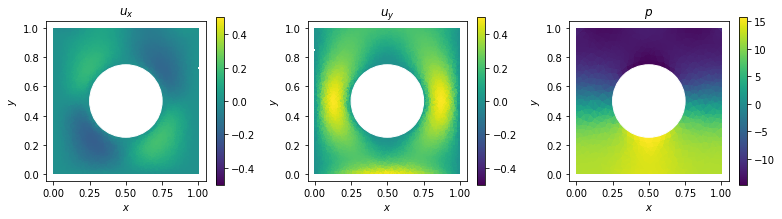

CPU times: user 6.75 s, sys: 1.65 s, total: 8.4 s
Wall time: 6.18 s


In [30]:
%%time

shading= 'flat' # flat or gouraud
max_u = 0.5
min_u = -0.5

fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(1, 3, 1)
plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], u1d_h + UP1, shading=shading, vmin=min_u, vmax=max_u)
circle1=plt.Circle((0.5,0.5),.25,color='w')
plt.gcf().gca().add_artist(circle1)
ax.set_title("$u_x$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.colorbar()
ax.set_aspect('equal')

fig.add_subplot(1, 3, 2, sharex=ax, sharey=ax)
plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], u2d_h + UP2, shading=shading, vmin=min_u, vmax=max_u)
circle1=plt.Circle((0.5,0.5),.25,color='w')
plt.gcf().gca().add_artist(circle1)
plt.title("$u_y$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.colorbar()
plt.gca().set_aspect('equal')

fig.add_subplot(1, 3, 3, sharex=ax, sharey=ax)
plt.tripcolor(fe_p['dof'][:,0], fe_p['dof'][:,1], p_h,  shading=shading)
circle1=plt.Circle((0.5,0.5),.25,color='w')
plt.gcf().gca().add_artist(circle1)
plt.title("$p$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.colorbar()
plt.gca().set_aspect('equal')

plt.tight_layout()
plt.savefig("figures/q09_1.png", dpi=900)
plt.show()

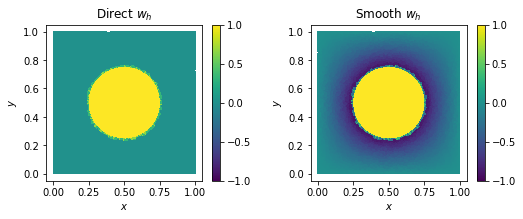

In [33]:
max_u = 1
min_u = -1

markers = fe_u['markers']
row = np.where(markers==0)[0]
col = np.arange(row.size)
data = np.ones((row.size, ), dtype=np.float)
P_u = sp.csr_matrix((data, (row, col)), shape=(markers.size, row.size))

w_h = np.zeros((dim_u1,), dtype=np.float)

w_h[np.logical_and(markers, (fe_u['dof'][:,0]-0.5)**2 + (fe_u['dof'][:,1]-0.5)**2 <= (0.25+1e-4)**2)] = 1.0

fig = plt.figure(figsize=(7.5,3))
ax = fig.add_subplot(1, 2, 1)
plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], w_h, vmin=min_u, vmax=max_u)
plt.title("Direct $w_h$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.colorbar()
plt.gca().set_aspect('equal')


_A = fe_u['DUX'].transpose().dot(W).dot(fe_u['DUX']) + fe_u['DUY'].transpose().dot(W).dot(fe_u['DUY'])
Aw = P_u.transpose().dot(_A).dot(P_u)
w_h_ref = P_u.dot(sp.linalg.spsolve(Aw, P_u.transpose().dot(A11).dot(w_h))) + w_h

fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], w_h_ref, vmin=min_u, vmax=max_u)
plt.title("Smooth $w_h$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.colorbar()
plt.gca().set_aspect('equal')

assert np.all(w_h_ref[np.logical_and(markers, (fe_u['dof'][:,0]-0.5)**2 + (fe_u['dof'][:,1]-0.5)**2 <= (0.25+1e-4)**2)] == 1.0)
assert np.all(w_h_ref[np.logical_and(markers, (fe_u['dof'][:,0]-0.5)**2 + (fe_u['dof'][:,1]-0.5)**2 > (0.25+1e-4)**2)] == 0.0)

plt.tight_layout()
plt.savefig("figures/q10_1.png", dpi=900)
plt.show()

### Calculate Force: Question 10

In [13]:
W = sp.spdiags(fe_u['w'], [0], m=dim_w, n=dim_w)

# LHS
var_formulation = 2 # 1 -> nabla(u) : nabla(v), 2 -> (nabla(u) + nabla(u)^T) : nabla(v)
if var_formulation == 1:
    A11 = fe_u['DUX'].transpose().dot(W).dot(fe_u['DUX']) + fe_u['DUY'].transpose().dot(W).dot(fe_u['DUY'])
    A22 = A11
    A12 = None
    A21 = None
elif var_formulation == 2:
    A11 = fe_u['DUX'].transpose().dot(W).dot(fe_u['DUX']) + fe_u['DUY'].transpose().dot(W).dot(fe_u['DUY'])
    A22 = A11
    A12 = fe_u['DUY'].transpose().dot(W).dot(fe_u['DUX'])
    A21 = A12.transpose()
else:
    raise NotImplementedError("No other Variational Formulations")

A13 = -fe_u['DUX'].transpose().dot(W).dot(fe_p['U'])
A23 = -fe_u['DUY'].transpose().dot(W).dot(fe_p['U'])

# _row = U.transpose().dot(W).dot(np.ones((dim_w,)))[None, :] # Force mean(p) = 0
A = sp.bmat([[A11, A12, A13], [A21, A22, A23], [A13.transpose(), A23.transpose(), None]], format='csr')
assert np.allclose((A - A.transpose()).data, 0), "A is not numerically symmetric!"


Fb_x = sp.bmat([[A11], [A21], [A13.transpose()]], format='csr').dot(w_h).dot(u_h)
Fb_y = sp.bmat([[A12], [A22], [A23.transpose()]], format='csr').dot(w_h).dot(u_h)

print("F_x = {}".format(Fb_x))
print("F_y = {}".format(Fb_y))

F_x = 0.0012968486062601634
F_y = -18.000429557519894
